# 14FEB23 In Class Exercise
Module: Introduction to Coalescent Theory & Tree-Thinking \
Topic: A hands on introduction to coalescent simulations using `msprime` and `tskit`.

When in doubt read the docs!
- [`msprime`](https://tskit.dev/msprime/docs/stable/intro.html)
- [`tskit`](https://tskit.dev/tskit/docs/stable/introduction.html)

In [1]:
# Import modules.
import demes
import demesdraw
from IPython.display import display, SVG
from matplotlib import pyplot as plt
import msprime
import numpy as np
import pandas as pd
# Print versions.
print('demes', demes.__version__)
print('demesdraw', demesdraw.__version__)
print('msprime', msprime.__version__)
print('numpy', np.__version__)

demes 0.2.2
demesdraw 0.3.1
msprime 1.2.0
numpy 1.23.5


## Coalescent Simulations with `msprime`
The package [`msprime`](https://tskit.dev/msprime/docs/stable/intro.html) has three main functionalities that we will utilize in this class. The first being ancestry simulations, the second being mutation simulations, and the last being demographic objects. Let's walk through them all now and then use them to recreate some results from lectures.

### Ancestry Simulations
Although this is the most basic kind of simulation, it will be extremely helpful for validating theoretical results. Let's run an ancestry simulation below.

In [2]:
# Perform an ancestry simulation for three samples with an effective population size of 1e6.
ts = msprime.sim_ancestry(
    samples=3,
    population_size=1e6,
    ploidy=1, # Simulate haploids.
    random_seed=42,
)
# Show the tree-sequence.
ts

The code above simulates a treesequence for three monoploid samples that originate from a population with an effective population size of one million. Take a look over the summary output. What makes sense? What doesn't? Perhaps it would be helpful to view the tree.

In [3]:
# Print the tree as a text output.
print(ts.draw_text())

359071.20┊   4   ┊
         ┊  ┏┻━┓ ┊
156422.69┊  3  ┃ ┊
         ┊ ┏┻┓ ┃ ┊
0.00     ┊ 0 1 2 ┊
         0       1



(3:359071.19587171322200,(1:156422.69424061314203,2:156422.69424061314203):202648.50163110007998);


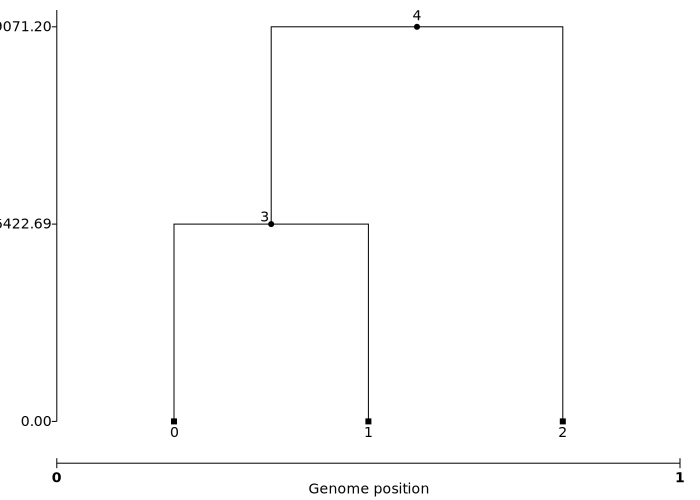

In [4]:
# Setting the tree drawing parameters.
draw_ts = ts.draw_svg(
    size=(700, 500),
    y_axis=True,
    y_label=' ',
    time_scale='rank',
    x_scale='treewise',
    )
# Print the newick format since the coal times are always cut off.
print(ts.first().newick())
# Draw the tree in a slightly more fancy way.
display(SVG(draw_ts))

So now that we can visualize the tree lets look at some of the tree properties that we discussed in lecture.

In [5]:
# Extract the first and only tree from the treesequence.
tree = ts.first()

In [6]:
# For every node...
for node in range(5): # There are 4 nodes.
    # If the node is a sample node...
    if tree.is_leaf(node):
        # Find the parent node.
        parent = tree.parent(node)
        # Find the branch length or amount of time between the child and parent node.
        coal_time = tree.branch_length(node)
        # Print a summary.
        print(f'node {node} is a leaf that finds its mrca with its parent node {parent}, {coal_time} generations ago')
    # Else...
    else:
        # Identify the children nodes.
        child_1, child_2 = tree.children(node)
        # Identify the time this parent node exists.
        coal_time = tree.time(node)
        # Print a summary.
        print(f'node {node} is the parent node of leaves {child_1} and {child_2} that coalesce {coal_time} generations ago')

node 0 is a leaf that finds its mrca with its parent node 3, 156422.69424061314 generations ago
node 1 is a leaf that finds its mrca with its parent node 3, 156422.69424061314 generations ago
node 2 is a leaf that finds its mrca with its parent node 4, 359071.1958717132 generations ago
node 3 is the parent node of leaves 0 and 1 that coalesce 156422.69424061314 generations ago
node 4 is the parent node of leaves 2 and 3 that coalesce 359071.1958717132 generations ago


In some instances we may need to traverse the tree by visiting every node. There are multiple different orderings in which we can visit all the nodes. Here is a quick overview:

- preorder: root $\rightarrow$ left subtree $\rightarrow$ right subtree
- inorder: left subtree $\rightarrow$ root $\rightarrow$ right subtree
- postorder: left subtree $\rightarrow$ right subtree $\rightarrow$ root

In [7]:
# For every travesal order.
for trav_order in ['preorder', 'inorder', 'postorder']:
    # Print the traversal order.
    print(f'{trav_order}:\t', list(tree.nodes(order=trav_order)))

preorder:	 [4, 2, 3, 0, 1]
inorder:	 [2, 4, 0, 3, 1]
postorder:	 [2, 0, 1, 3, 4]


In some cases the actual order doesn't make a difference. For, exmaple let's calculate the total branch length using the the tree-traversel method and the built in functionality.

In [8]:
# Calculate the totatl branch length by traversing the tree.
trav_tot_bl = sum(tree.branch_length(u) for u in tree.nodes())
# Calculate the total branch length using the built in functionality.
tskit_tot_bl = tree.total_branch_length 
# Print a summary.
print(f'total branch length: {trav_tot_bl} (traversal) vs {tskit_tot_bl} (tskit)')

total branch length: 874565.0859840396 (traversal) vs 874565.0859840396 (tskit)


Does this all make sense? I have added a couple of blank cells for you to play around simulating with different sample and effective population sizes. What general patterns emerge?

### Mutation Simulation
We will often want to simulate genetic variation under a nuetral model, which is where mutation simulations come in! Let's overlay mutations, onto the tree we originally simulated.

In [9]:
# Perform an ancestry simulation for three samples with an effective population size of 1e6.
ts = msprime.sim_ancestry(
    samples=3,
    population_size=1e6,
    ploidy=1, # Simulate haploids.
    random_seed=42,
)
# Overlay mutations at a rate of 2.5e-6 per base pair per generation.
mts = msprime.sim_mutations(
    tree_sequence=ts,
    rate=2.5e-6,
    random_seed=24,
    discrete_genome=False,
)
# Show the mutated tree-seequence.
mts

What looks different about the summary of this tree sequence? Let's take a look to see what is going on!

(3:359071.19587171322200,(1:156422.69424061314203,2:156422.69424061314203):202648.50163110007998);


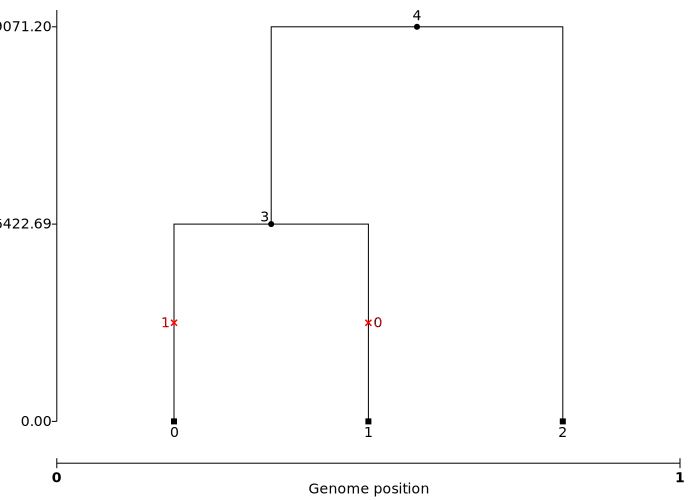

In [10]:
# Setting the tree drawing parameters.
draw_mts = mts.draw_svg(
    size=(700, 500),
    y_axis=True,
    y_label=' ',
    time_scale='rank',
    x_scale='treewise',
    )
# Print the newick format since the coal times are always cut off.
print(mts.first().newick())
# Draw the tree in a slightly more fancy way.
display(SVG(draw_mts))

Now we can clearly see that two mutations have occured on the external branches leading to sample nodes 0 and 1. Now let's view some more tree properties.

In [11]:
# Extract the first and only tree from the treesequence.
tree = mts.first()
# Extract the genotype matrix.
geno_mat = mts.genotype_matrix()

In [12]:
# Find the number of mutations on this tree.
n_muts = tree.num_mutations
# Print a summary.
print(f'there are {n_muts} mutations on this tree')
# For every mutation on the tree...
for mut in mts.mutations():
    # Print the mutation summary.
    print(mut)

there are 2 mutations on this tree
Mutation(id=0, site=0, node=1, derived_state='T', parent=-1, metadata=b'', time=153911.9953879932, edge=1)
Mutation(id=1, site=1, node=0, derived_state='C', parent=-1, metadata=b'', time=8267.661723209705, edge=0)


In [13]:
# View the genotype matrix.
geno_mat

array([[0, 1, 0],
       [1, 0, 0]], dtype=int32)

How does the tree differ once we add mutations? Does the genotype matrix for this tree make sense? Take the next couple of cells to play around by adjusting the sample size, effective population size, and mutation rate. For 99.99% of this class we will use the option `discrete_genome=False` why do you think that is? Play around by changing it to `True`. What happens? Once you are done playing with the tree-sequences and mutation simulations read this [`sim_ancestry` section](https://tskit.dev/msprime/docs/stable/ancestry.html#sec-ancestry-discrete-genome) and this [`sim_mutations` section](https://tskit.dev/msprime/docs/stable/mutations.html#discrete-or-continuous) about simultaing disrete genomes. Why do you think we will use the option `discrete_genome=False` so much in this course?

### Demography
So far we have been only simulating one population with a constant effective population size. This is very useful for validating classical population genetic theory, but we can produce some more realistic simulations by using demographic objects. Let's start off by creating a demographic model from [Racimo et al., 2017](https://academic.oup.com/mbe/article/34/2/296/2633371) figure 2A. __Note:__ this is a neutral version of model A using since the original paper used a WF-simulator.

In [14]:
# Define a function for model a from figure 2a.
def racimo_model_a(f):
    # Intialize demographic model.
    model = msprime.Demography()
    # We assume constant and equal effective population sizes for
    # all lineages.
    model.add_population(name='AFR', initial_size=10_000)
    model.add_population(name='EUR', initial_size=10_000)
    model.add_population(name='NEA', initial_size=10_000)
    model.add_population(name='AMH', initial_size=10_000)
    model.add_population(name='HUM', initial_size=10_000)
    # Introgression from the Neanderthal to the Eurasian lineage
    # occuring 1,600 generations ago with a probability of f.
    model.add_mass_migration(
        time=1_600, source='EUR', dest='NEA', proportion=f,
    )
    # The African and Eurasian lineages merge into the anatomically
    # modern human lineage 4,000 generations ago.
    model.add_population_split(
        time=4_000, derived=['AFR', 'EUR'], ancestral='AMH',
    )
    # The anatomically modern human and Neanderthal lineages merge
    # into the ancestral human lineage 16,000 generations ago.
    model.add_population_split(
        time=16_000, derived=['AMH', 'NEA'], ancestral='HUM',
    )
    return model

In [15]:
# Intialize a model with an introgression prbability of 0.1 .
racimo_f01_demo = racimo_model_a(0.1)

In [16]:
# Show the demography summary.
racimo_f01_demo

Demography(populations=[Population(initial_size=10000, growth_rate=0, name='AFR', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=0), Population(initial_size=10000, growth_rate=0, name='EUR', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=1), Population(initial_size=10000, growth_rate=0, name='NEA', description='', extra_metadata={}, default_sampling_time=None, initially_active=None, id=2), Population(initial_size=10000, growth_rate=0, name='AMH', description='', extra_metadata={}, default_sampling_time=4000, initially_active=False, id=3), Population(initial_size=10000, growth_rate=0, name='HUM', description='', extra_metadata={}, default_sampling_time=16000, initially_active=False, id=4)], events=[MassMigration(time=1600, source='EUR', dest='NEA', proportion=0.1), PopulationSplit(time=4000, derived=['AFR', 'EUR'], ancestral='AMH'), PopulationSplit(time=16000, derived=['AMH', 'NEA'], ancestral='HUM')], migration_matrix=array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]]))

In [17]:
# Print the demography debugger.
racimo_f01_demo.debug()

Carefully look over figure 2A  from [Racimo et al., 2017](https://academic.oup.com/mbe/article/34/2/296/2633371) and the demographic model above. Are the two consistent, why or why not? Thinking about time from a coalescent prospective is not always intuitve at first, so let's convert the demographic obeject to a `demes` graph and plot it using `demesdraw`.

In [18]:
# Convert the demographic object to a demes graph.
racimo_f01_graph = msprime.Demography.to_demes(racimo_f01_demo)

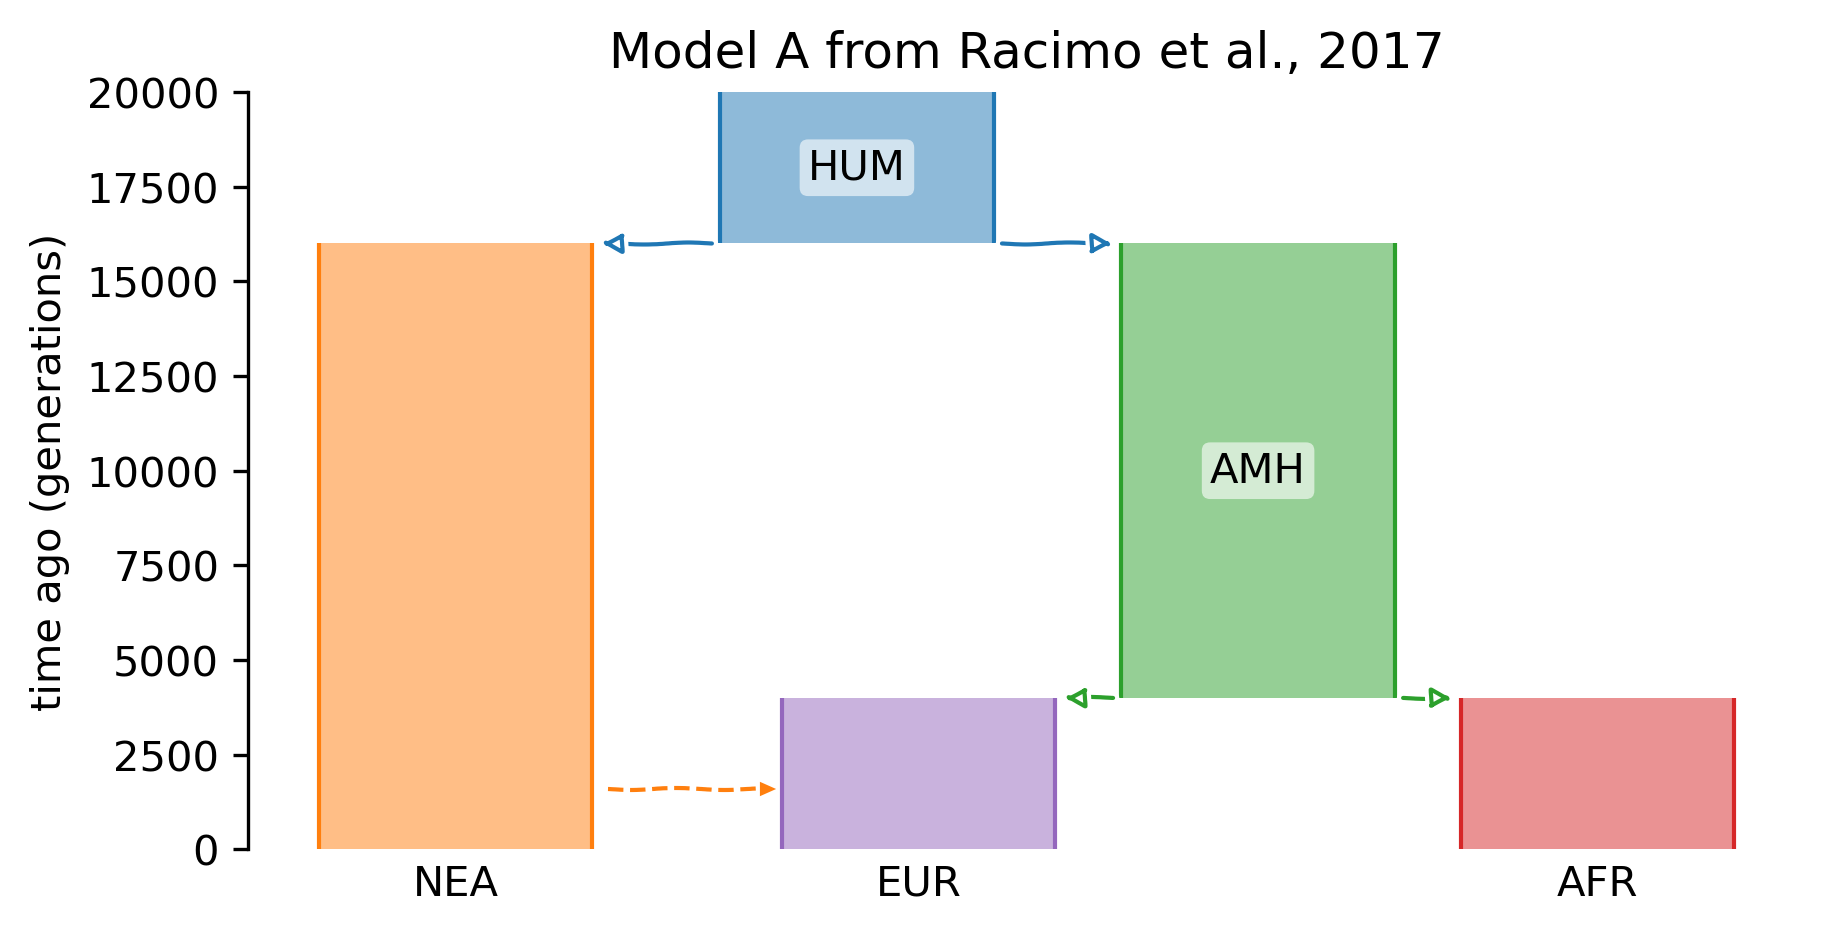

In [19]:
# Intialize the figure.
fig = plt.figure(
    figsize=(6, 3),
    constrained_layout=True,
    dpi=300.0,
)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the demes graph.
demesdraw.tubes(
    racimo_f01_graph,
    ax=ax,
    title='Model A from Racimo et al., 2017',
    seed=42,
)
# Show the plot.
plt.show()

Now that you have visualized the the demographic model, go back and read over the demography debugger. Does everything make sense now? If not, look through the `msprime` documentation and then ask your instructor if you are still confused.

#### A Quick Aside About `demes` & `demesdraw`

Just a quick aside, but as you have probably already noticed it is quite easy to make coding mistakes or simply write down the wrong parameters. In fact there is a [scientific paper](https://www.sciencedirect.com/science/article/pii/S000292972030286X) on that was published in 2020 about this exact issue! However, a good thing that came out of this was `demes` (a new file format for demographic models) and `demesdraw` (a quick and easy way to visualize demographic models). I will often use `demes` graphs instead of demogrpahic objects. Let's look at one now.

In [20]:
# Load the demographic model as a demes graph.
org_ooa_aa_graph = demes.load('../data/HomSap__OutOfAfricaArchaicAdmixture_5R19.yaml')

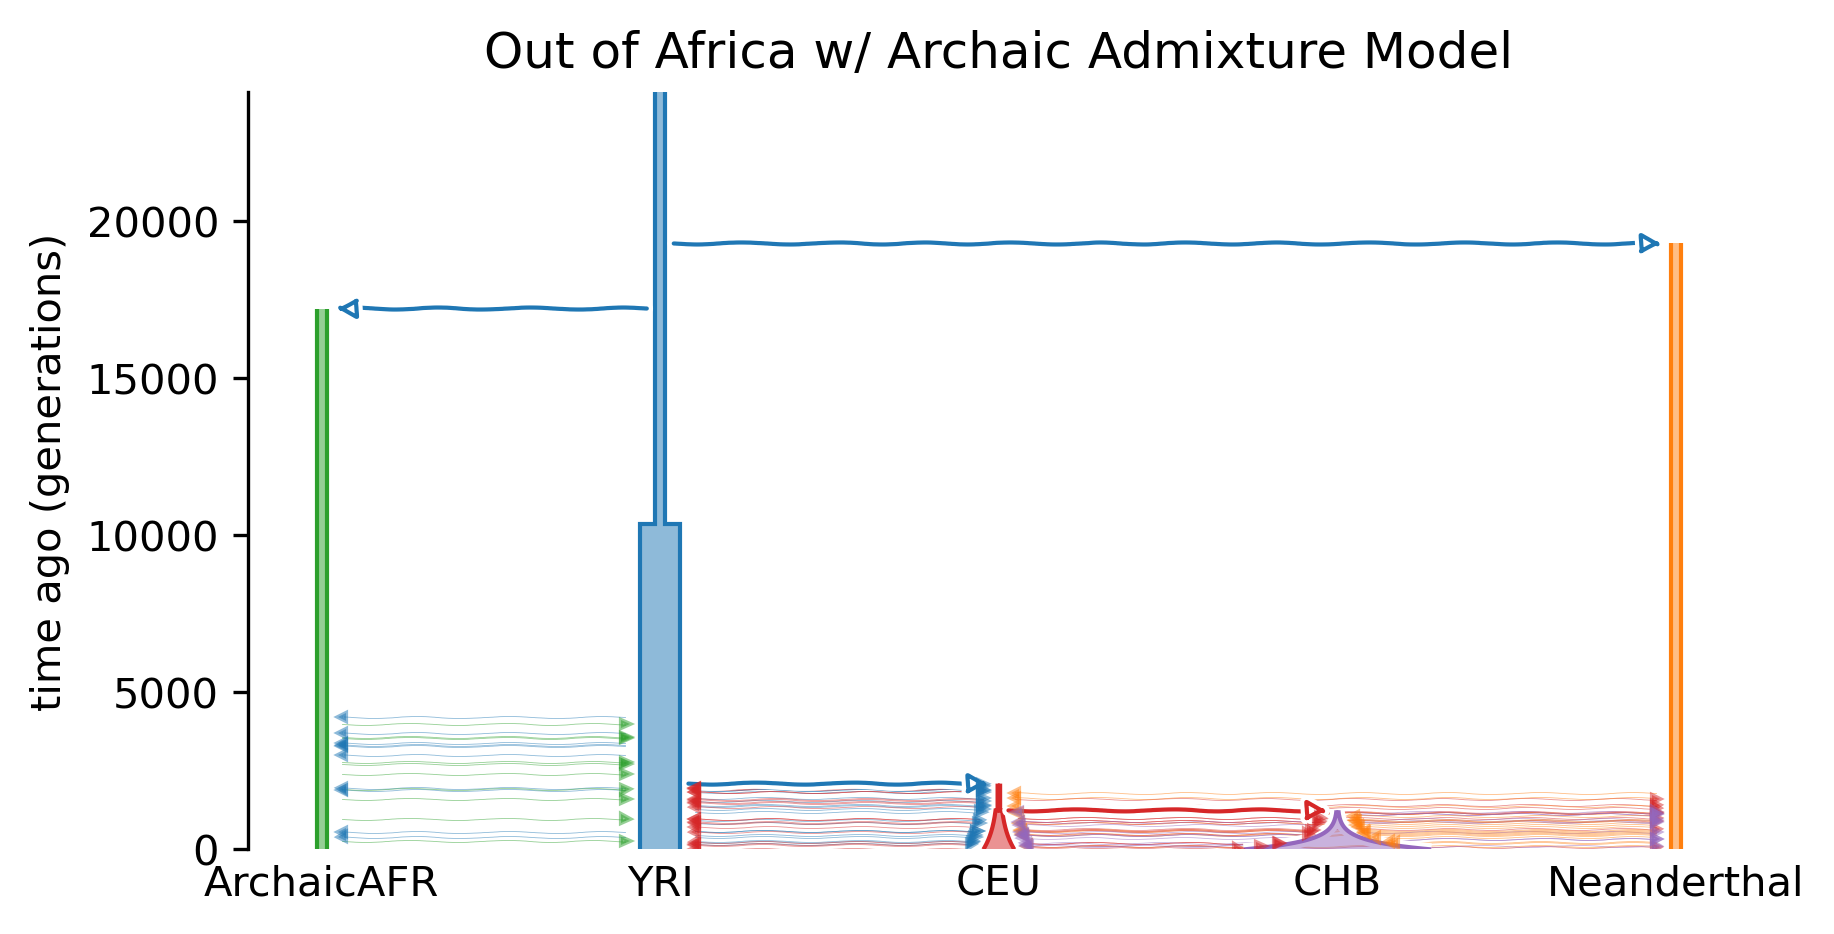

In [21]:
# Intialize the figure.
fig = plt.figure(
    figsize=(6, 3),
    constrained_layout=True,
    dpi=300.0,
)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the demes graph.
demesdraw.tubes(
    org_ooa_aa_graph,
    ax=ax,
    title='Out of Africa w/ Archaic Admixture Model',
    seed=42,
)
# Show the plot.
plt.show()

In [22]:
# Convert the graph to a demographic object.
org_ooa_aa_demo = msprime.Demography.from_demes(org_ooa_aa_graph)
# Print the demography debugger.
org_ooa_aa_demo.debug()

Ok now back to our regulary scheduled programming—haha get it because we are coding... So far, we have ignored recombination, however, recombination is a very important process as it creates multiple tree along the genome that are spatially autocorrelated. Let's simulate a neutral version of Model A from [Racimo et al., 2017](https://academic.oup.com/mbe/article/34/2/296/2633371) to see demography + recombination in action!

In [23]:
# Simulate a segment of 10kb, with a recombination rate of 1e-8 and sample
# one monoploid genome from the focal populations.
racimo_f01_ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(1, ploidy=1, population='AFR'),
        msprime.SampleSet(1, ploidy=1, population='EUR'),
        msprime.SampleSet(1, ploidy=1, population='NEA'),
    ],
    demography=racimo_f01_demo,
    record_migrations=True,  # Needed for tracking segments later.
    sequence_length=10_000,
    recombination_rate=1e-8,
    random_seed=42,
)
# Show the tree-sequence summary.
racimo_f01_ts

How does this tree-sequence summary differ from the ones before? Let's start by visualizing the tree-sequence.

In [24]:
# Print the tree as a text output.
print(racimo_f01_ts.draw_text())

26530.73┊       ┊       ┊   7   ┊       ┊  
        ┊       ┊       ┊ ┏━┻┓  ┊       ┊  
21014.99┊       ┊   6   ┊ ┃  ┃  ┊       ┊  
        ┊       ┊ ┏━┻┓  ┊ ┃  ┃  ┊       ┊  
20907.69┊   5   ┊ ┃  5  ┊ ┃  5  ┊   5   ┊  
        ┊  ┏┻━┓ ┊ ┃ ┏┻┓ ┊ ┃ ┏┻┓ ┊  ┏┻━┓ ┊  
18146.08┊  4  ┃ ┊ ┃ ┃ ┃ ┊ ┃ ┃ ┃ ┊  ┃  ┃ ┊  
        ┊ ┏┻┓ ┃ ┊ ┃ ┃ ┃ ┊ ┃ ┃ ┃ ┊  ┃  ┃ ┊  
10226.00┊ ┃ ┃ ┃ ┊ ┃ ┃ ┃ ┊ ┃ ┃ ┃ ┊  3  ┃ ┊  
        ┊ ┃ ┃ ┃ ┊ ┃ ┃ ┃ ┊ ┃ ┃ ┃ ┊ ┏┻┓ ┃ ┊  
0.00    ┊ 0 1 2 ┊ 0 1 2 ┊ 0 1 2 ┊ 0 1 2 ┊  
        0     3223    3896    5639    10000



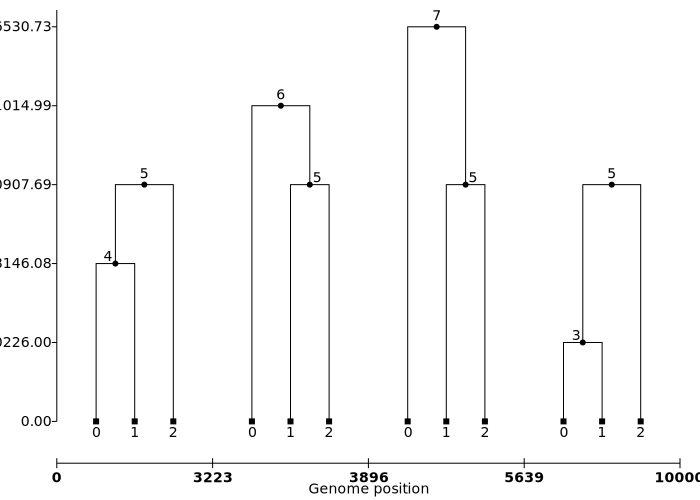

In [25]:
# Setting the tree drawing parameters.
draw_racimo_f01_ts = racimo_f01_ts.draw_svg(
    size=(700, 500),
    y_axis=True,
    y_label=' ',
    time_scale='rank',
    x_scale='treewise',
    )
# Draw the tree in a slightly more fancy way.
display(SVG(draw_racimo_f01_ts))

Now, we can clearly see that the recombination process produced multiple trees broken seperated by the recombination brake points. Now let's view some properties of the tree-sequence.

In [26]:
# Find the number of trees.
n_trees = racimo_f01_ts.num_trees
# Pint a summary.
print(f'there are {n_trees} trees in this tree-sequence')
# Find all of the breakpoints including the start and end of the sequence.
break_points = racimo_f01_ts.breakpoints(as_array=True)
# For every breakpoint...
for break_point in break_points[1:-1]:
    # Print a summary.
    print(f'there is a breakpoint at position {break_point}')
# For every tree....
for tree in racimo_f01_ts.trees():
    # Print the tree summary.
    print(f'tree {tree.index} covers {tree.interval}')

there are 4 trees in this tree-sequence
there is a breakpoint at position 3223.0
there is a breakpoint at position 3896.0
there is a breakpoint at position 5639.0
tree 0 covers Interval(left=0.0, right=3223.0)
tree 1 covers Interval(left=3223.0, right=3896.0)
tree 2 covers Interval(left=3896.0, right=5639.0)
tree 3 covers Interval(left=5639.0, right=10000.0)


Now, let's overlay some mutations to our tree-sequence.

In [27]:
# Simulate a segment of 10kb, with a recombination rate of 1e-8 and sample
# one monoploid genome from the focal populations.
racimo_f01_ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(1, ploidy=1, population='AFR'),
        msprime.SampleSet(1, ploidy=1, population='EUR'),
        msprime.SampleSet(1, ploidy=1, population='NEA'),
    ],
    demography=racimo_f01_demo,
    record_migrations=True,  # Needed for tracking segments later.
    sequence_length=10_000,
    recombination_rate=1e-8,
    random_seed=42,
)
# Overlay mutations at a rate of 1.5e-8 per base pair per generation.
racimo_f01_mts = msprime.sim_mutations(
    tree_sequence=racimo_f01_ts,
    rate=1.5e-8,
    random_seed=42,
    discrete_genome=False,
)
# Show the tree-sequence summary.
racimo_f01_mts

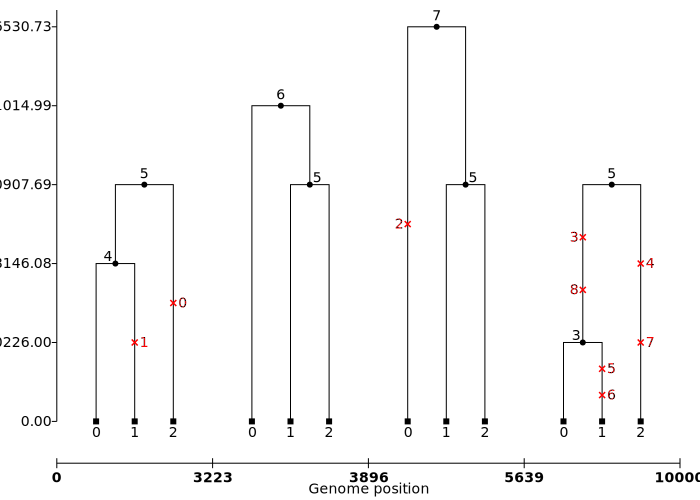

In [28]:
# Setting the tree drawing parameters.
draw_racimo_f01_mts = racimo_f01_mts.draw_svg(
    size=(700, 500),
    y_axis=True,
    y_label=' ',
    time_scale='rank',
    x_scale='treewise',
    )
# Draw the tree in a slightly more fancy way.
display(SVG(draw_racimo_f01_mts))

### Tables
So I specifically kept migrations turned on and overlayed mutations to highlight the table functionality. Let's take a look at them now.

#### Node Table
The node table records the information associated with a node which represents an ancestral haploid genome—__NOTE:__ The `id` column is only visualized but not actually recorded. 
- `flags` column has a value of 1 if the node is a sample node and 0 otherwise.
- `population` column records the population id for the node and is -1 otherwise.
- `individual` column records the individual id for the node and is -1 otherwise.
- `time` column records the birth time of that node.
- `metadata` column contains any associated metadata for that node.  

In [29]:
# View the node table.
racimo_f01_mts.tables.nodes

id,flags,population,individual,time,metadata
0,1,0,0,0.00000000,
1,1,1,1,0.00000000,
2,1,2,2,0.00000000,
3,0,3,-1,10226.00100408,
4,0,4,-1,18146.08195708,
5,0,4,-1,20907.68806381,
6,0,4,-1,21014.98867161,
7,0,4,-1,26530.72983536,


#### Edge Table
The edge table records the parent-child relationship between a pair of nodes over a genomic interval—__NOTE:__ The `id` column is only visualized but not actually recorded. 
- `left` column records the left coordinate (inclusive) of the half open genomic interval `[left, right)` over which the `child` node is inherited from a given `parent` node.
- `right` column records the right coordinate (inclusive) of the half open genomic interval `[left, right)` over which the `child` node is inherited from a given `parent` node.
- `parent` column records the node id of the `parent` node.
- `child` column records the node id of the `child` node.
- `metadata` column contains any associated metadata for that node. 

In [30]:
racimo_f01_mts.tables.edges

id,left,right,parent,child,metadata
0,5639,10000,3,0,
1,5639,10000,3,1,
2,0,3223,4,0,
3,0,3223,4,1,
4,3223,5639,5,1,
5,0,10000,5,2,
6,5639,10000,5,3,
7,0,3223,5,4,
8,3223,3896,6,0,
9,3223,3896,6,5,


#### Migrations Table
The migration table records the genomic segments that have moved between populations—__NOTE:__ The `id` column is only visualized but not actually recorded. 
- `left` column records the left coordinate (inclusive) of the half open genomic interval `[left, right)` of the migrating genomic segment.
- `right` column records the right coordinate (inclusive) of the half open genomic interval `[left, right)` of the migrating genomic segment.
- `node` column records the ancestral node associated with the genomic segment at the time of migration. 
- `source` column records the population id of the migrating genomic segment—i.e., introgression from `dest` to `source` (forwards in time).
- `dest` column records the population id of the migrating genomic segment—i.e., introgression from `dest` to `source` (forwards in time).
- `time` column records the birth time of the migration event.
- `metadata` column contains any associated metadata for that node. 

In [31]:
racimo_f01_mts.tables.migrations

id,left,right,node,source,dest,time,metadata
0,3896,10000,0,0,3,4000,
1,0,3896,0,0,3,4000,
2,0,10000,1,1,3,4000,
3,3423,5639,1,3,4,16000,
4,5639,10000,3,3,4,16000,
5,3223,3896,0,3,4,16000,
6,3896,5639,0,3,4,16000,
7,0,3423,1,3,4,16000,
8,0,3223,0,3,4,16000,
9,1933,10000,2,2,4,16000,


#### Site Table
The site table records the genomic positions and ancestral state of mutated sites.
- `id` column record the variable site id.
- `position` column records the genomic coordinates of the mutated site.
- `ancestral_state` column records the ancestral allelic state as specified by the root of the tree.

In [32]:
racimo_f01_mts.tables.sites

id,position,ancestral_state,metadata
0,205.84498765,G,
1,322.21916880,C,
2,4648.88017166,A,
3,5642.39619294,T,
4,7080.72578302,A,
5,8249.74965862,A,
6,8831.22556506,G,
7,9699.09847016,C,
8,9966.03463152,T,


#### Mutation Table
The mutation table records the genomic positions and ancestral state of mutated sites—__NOTE:__ The `id` column is only visualized but not actually recorded. 
- `site` column records the variable site id that was mutated.
- `node` column records the id of the first node below the mutation (ie the node that inherits the mutation).
- `time` column records the how many generations ago the mutation arose.
- `derived_state` column records the allelic state resulting from the mutation.
- `parent` column records information about multiple hit mutations (don't worry about this).

In [33]:
racimo_f01_mts.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,2,1179.43564376,C,-1,
1,1,1,1053.98996693,A,-1,
2,2,0,611.86305881,C,-1,
3,3,3,12168.19840156,C,-1,
4,4,2,13608.57316327,G,-1,
5,5,1,6103.39035018,T,-1,
6,6,1,7973.12092271,A,-1,
7,7,2,15095.32509530,G,-1,
8,8,3,12185.07058427,C,-1,


Ok that was a lot of information. Make sure you take the time to play with around in some extra cells to make sure that you fully understand what is going on. Refernce the documentation and ask your instructor questions!

## Challenge: Validating the Expected Waiting Times Until the First Coalescent Event
Using simulations without recombination or mutations validate the expected waiting times until the first coalescent event as a function of $i$ haploid samples—ie $\mathbb{E} \left(T_{i} \right) = \frac{N}{\binom{i}{2}}$. Make a plot and table to compare the analytical results versus the mean of 1,000 replicate simulations using the following parameters:

- $N$ = 10,000
- $i$ = 2, 3, 4, 5, 6, 7, 8, 9, 10

In [34]:
# Define a function to calcualte the analytical solutions.
def e_t_i(N, i):
    return (N / ((i * (i - 1)) / 2))

In [35]:
# Intialize an array of sample sizes.
sample_sizes = np.array([
    2, 3, 4,
    5, 6, 7,
    8, 9, 10,
])
# Define the number of replicate simulations to run.
n_reps = 1_000
# Intialize an empty array to store the results.
sim_mean_t_i = np.array([])
# For every sample size...
for samps in sample_sizes:
    # Intialize an empty list to store results.
    t_i = []
    # For every tree-sequence...
    for ts in msprime.sim_ancestry(
        samples=samps,
        population_size=10_000,
        ploidy=1,
        discrete_genome=False,
        num_replicates=n_reps,
    ):
        # Extract the first tree.
        tree = ts.first()
        # Append the results. 
        t_i.append(tree.time(samps))
    # Append the mean from 1000 simulations.
    sim_mean_t_i = np.append(sim_mean_t_i, np.mean(np.array(t_i)))
# Calculate the analytical solutions.
exp_t_i = np.array([e_t_i(N=10_000, i=n) for n in sample_sizes])
# Intialize a df dictionary.
df_dicc = {
    'Simulated Results': np.round(sim_mean_t_i, 3),
    'Analytical Results': np.round(exp_t_i, 3),
}
# Generate a list of indicies.
df_idx = [
    r'$T_{2}$', r'$T_{3}$', r'$T_{4}$',
    r'$T_{5}$', r'$T_{6}$', r'$T_{7}$',
    r'$T_{8}$', r'$T_{9}$', r'$T_{10}$',
]
# Intialize the results data frame.
t_i_df = pd.DataFrame(data=df_dicc, index=df_idx)

In [36]:
# Show the results.
t_i_df

,Simulated Results,Analytical Results
$T_{2}$,9979.845,10000.000
$T_{3}$,3116.231,3333.333
$T_{4}$,1696.380,1666.667
$T_{5}$,994.186,1000.000
$T_{6}$,671.751,666.667
$T_{7}$,500.008,476.190
$T_{8}$,348.778,357.143
$T_{9}$,291.867,277.778
$T_{10}$,225.828,222.222


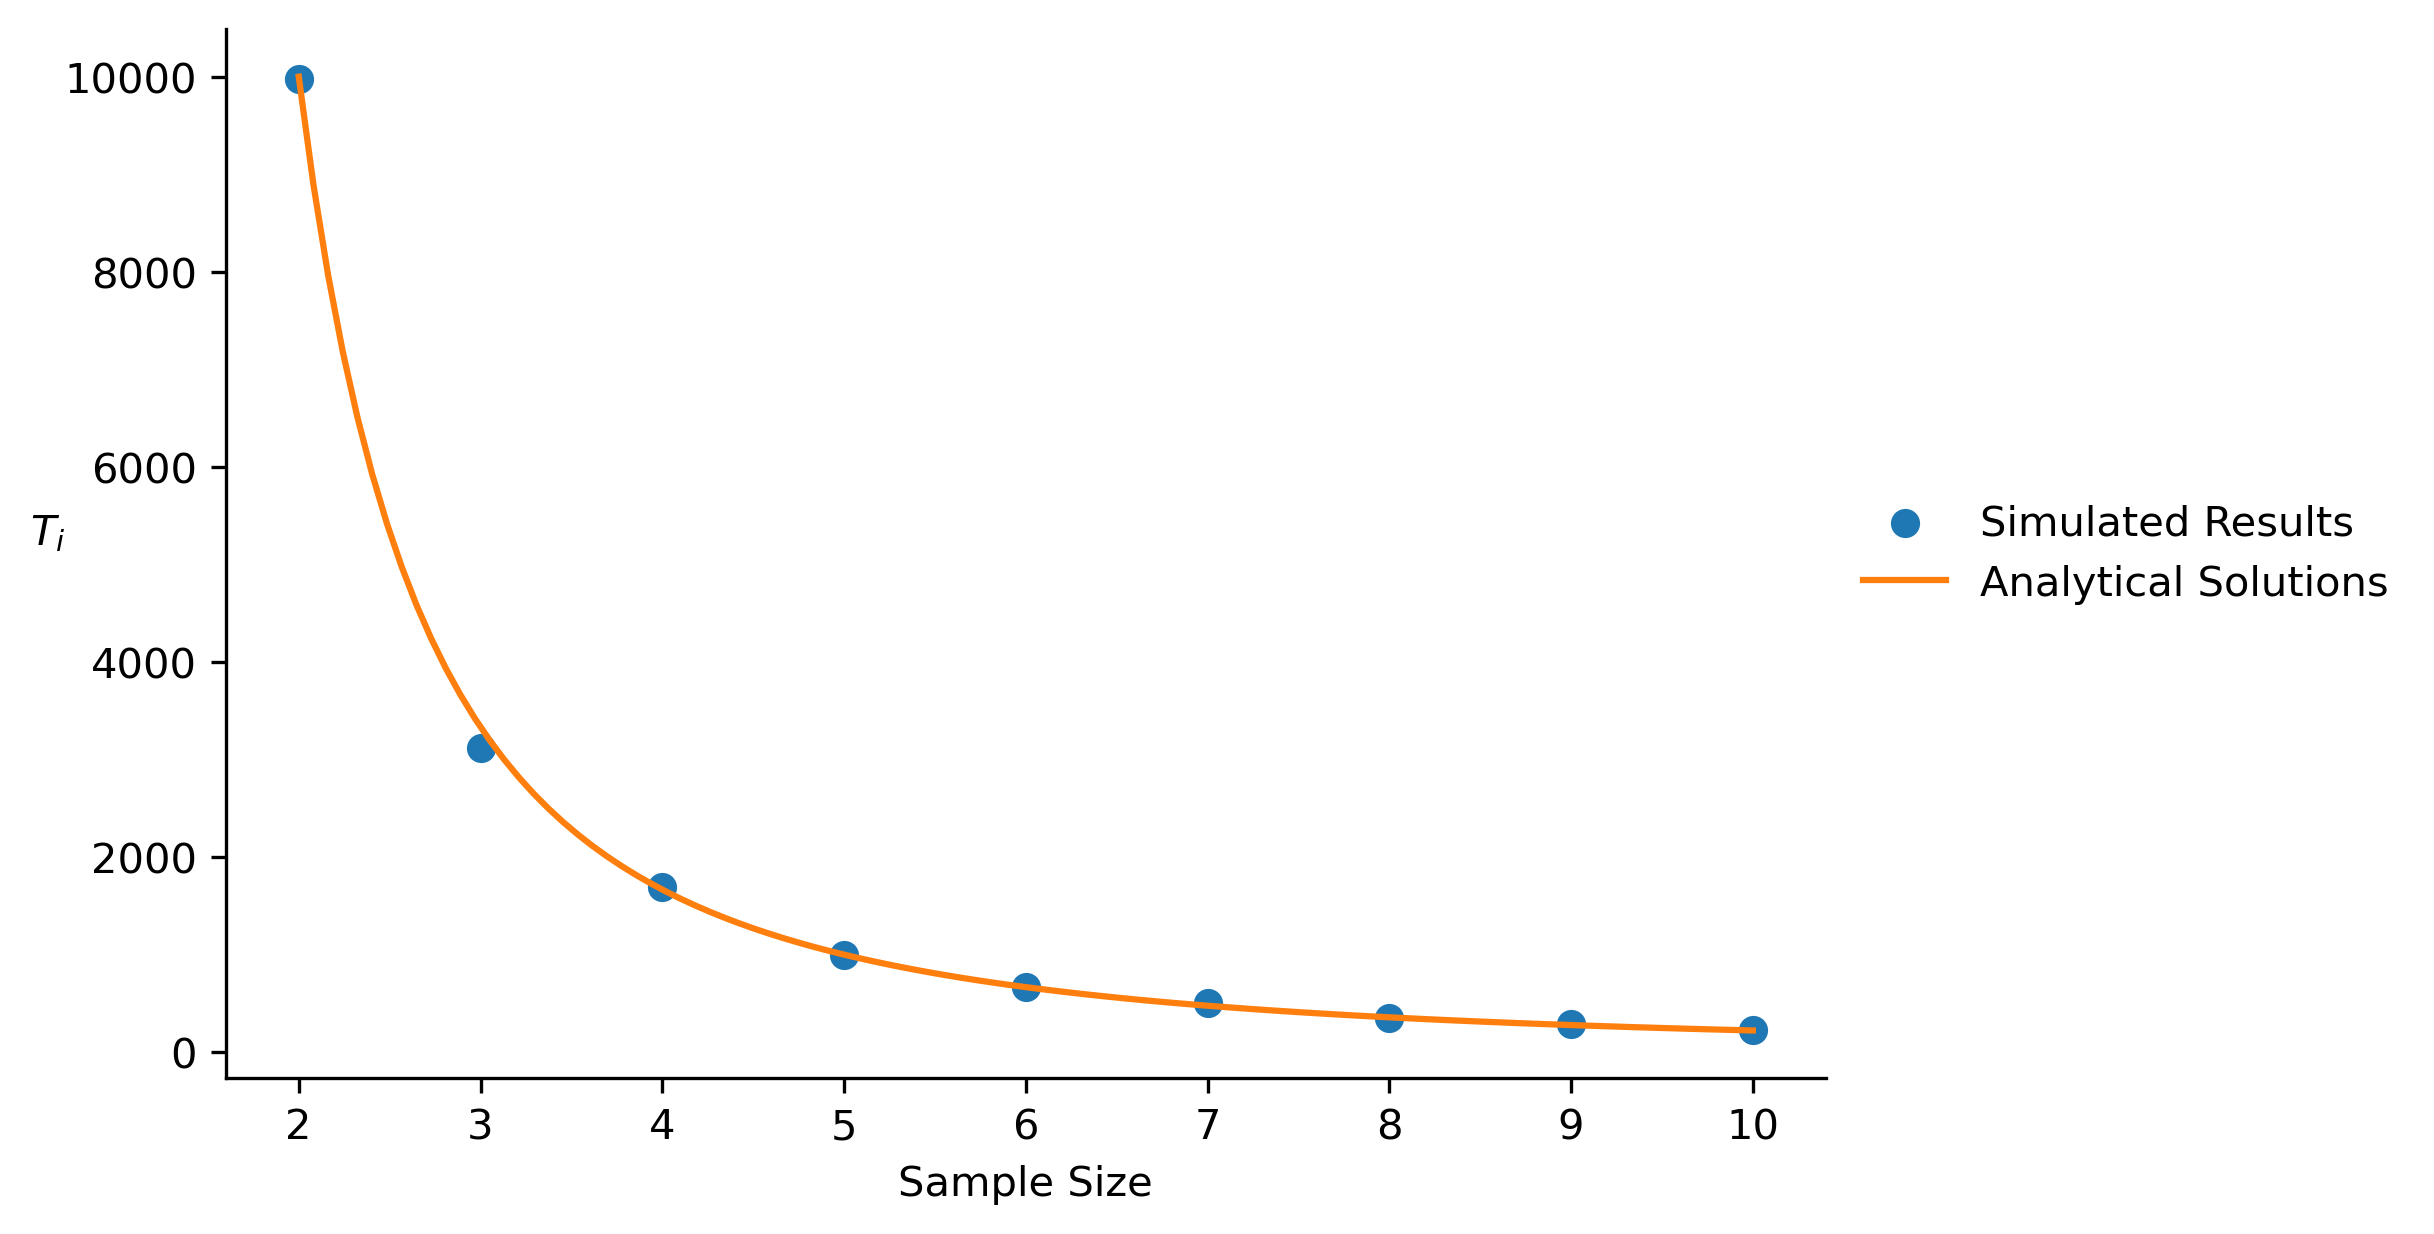

In [37]:
# Intialize the figure.
fig = plt.figure(figsize=(8, 4), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the simulated results.
ax.scatter(
    sample_sizes, sim_mean_t_i,
    color='tab:blue', label='Simulated Results',
)
# Plot the analytical solutions.
ax.plot(
    np.linspace(2, 10, 100),
    np.array([e_t_i(N=10_000, i=n) for n in np.linspace(2, 10, 100)]), 
    color='tab:orange', label='Analytical Solutions',
)
# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Label the x-axis ticks.
ax.set_xticks(sample_sizes)
# Plot the legend.
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
# Label the axes.
plt.xlabel('Sample Size')
plt.ylabel(r'$T_{i}$', rotation=0)
# Show!
plt.show()

Based on the table and the plot above our simulations closely mirror our anayltical expectations! The plot and table also highlight that waiting times until the first coalescent event decrease as the sample size increases!